# Balance de Masa Superficial - Modelo de Lliboutry
### Autor: Rubén Basantes

### Configuración de entorno de trabajo

In [1]:
system("git clone https://github.com/jpanimboza/Repo_prueba_Mass_Balance.git", intern = TRUE)

# Cambia al directorio
setwd("Repo_prueba_Mass_Balance")

character(0)

### Instalación y carga de librerías

In [2]:
suppressPackageStartupMessages({
  source("Libraries.R")    
})

## Carga de datos

In [3]:
rm(list = ls())
rawData <- "data/bmantisana15.txt"
shapes_path <- "data/"
m <- 50 # range for the calculation of the balance by the weighted area method
Resolution <- 100 # It is the resolution of the raster to be used. Cell size = mxm units
N.Obs <- 6
crsID <- "EPSG:32717"
dem <- "data/Antisana_ALOS.tif"
summit <- 5700

#### Crear un cuaderno de trabajo

In [4]:
wb <- createWorkbook()

## Balance de masa según el modelo de Lliboutry

In [5]:
source("funciones/Lliboutry_NL.R")
NLMR <- NLM(rawData, shapes_path, dem, Resolution, crsID, N.Obs, summit)

Reading layer `Antisana15a_1999' from data source 
  `/kaggle/working/Repo_prueba_Mass_Balance/data/Antisana15a_1999.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 816781.9 ymin: 9946475 xmax: 818009.4 ymax: 9947552
Projected CRS: WGS 84 / UTM zone 17S


In [6]:
e_obs_mod <- NLMR$e_obs_mod
Nyear <- NLMR$Nyear
bit_LM <- NLMR$bit_LM
bit_LMf <- NLMR$bit_LMf
bo_t <- NLMR$bo_t
beta_it <- NLMR$beta_it
brick_raw <-NLMR$brick_raw
rawData <- NLMR$rawData
shap <- NLMR$shap
shape_list <- NLMR$shape_list
ai_df <- NLMR$ai_df
XY_coords <- NLMR$XY_coords
e_obs_mod_sd.tot <- sd(unlist(e_obs_mod[-c(1:3)]), na.rm=T)

#### Verificar normalidad con la prueba de Shapiro - Wilk

In [7]:
shapiro_result <- shapiro.test(unlist(e_obs_mod[Nyear]))

#### Creación del archivo Brick de salidas del modelo de Balance de Masa

In [8]:
brick_list <- list(
    LM = bit_LM, 
    LMf = bit_LMf, 
    beta_it = beta_it, 
    e_obs_mod = e_obs_mod) 
source("funciones/BrickBuilder.R")
brick_list <- BrickBuilder(brick_list,brick_raw,Nyear)
brick_list$Raw <- brick_raw
brick_list <- brick_list[c("Raw", names(brick_list)[-5])] 
n.stk.abl <- sum(rawData$nf[which(rawData$ai<0)]/length(Nyear))
n.stk.acc <- sum(rawData$nf[which(rawData$ai>0)]/length(Nyear))

## Cálculo del balance de masa distribuido para datos sin ajuste geodésico

### Método de interpolación de área ponderada

In [9]:
source("funciones/B_LMf_W.R")
aux = 0
WAreaR = WArea(bit_LMf, m, shapes_path, dem, crsID, shap, Nyear,aux)
bit_LMf_w_a <- WAreaR$bit_LMf_w_a
B_LMf_w <- WAreaR$B_LMf_w
stat.w.sd <- WAreaR$stat.w.sd
bit_LMf_w_a <-WAreaR$bit_LMf_w_a
addWorksheet(wb, "out_bit_LMf_w_a_rg")
writeData(wb, sheet = "out_bit_LMf_w_a_rg", bit_LMf_w_a)

Reading layer `Antisana15a_1999' from data source 
  `/kaggle/working/Repo_prueba_Mass_Balance/data' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 816781.9 ymin: 9946475 xmax: 818009.4 ymax: 9947552
Projected CRS: WGS 84 / UTM zone 17S
Reading layer `Antisana15a_1999' from data source 
  `/kaggle/working/Repo_prueba_Mass_Balance/data' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 816781.9 ymin: 9946475 xmax: 818009.4 ymax: 9947552
Projected CRS: WGS 84 / UTM zone 17S
Reading layer `Antisana15a_1999' from data source 
  `/kaggle/working/Repo_prueba_Mass_Balance/data' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 816781.9 ymin: 9946475 xmax: 818009.4 ymax: 9947552
Projected CRS: WGS 84 / UTM zone

Joining with `by = join_by(ranges)`


### Método de interpolación IDW

In [10]:
suppressMessages(suppressWarnings(invisible({
aux = 0
source("funciones/B_LMf_Idw.R")
IdwGBR = IdwGB(bit_LMf, dem, crsID, brick_raw, Nyear, aux)
    })))
bit_LMf_idw <- IdwGBR$bit_LMf_idw
stat.idw.CV_LMf <- IdwGBR$stat.idw.CV_LMf
att <- BrickBuilder(list(LMf_idw = bit_LMf_idw), brick_raw, Nyear)
brick_list$LMf_idw <- lapply(setNames(1:length(Nyear), Nyear), function(i){
    raster::mask(att$LMf_idw[[i]], as(st_zm(st_as_sf(shape_list[[shap[i]]])), "Spatial"))
}) %>% brick()

[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpo

#### Cálculo del balance de masa neto anual par ala distribución usando el método IDW

In [11]:
B_LMf_idw <-data.frame(area_glc = sapply(1:length(Nyear), function(i){
    sum(st_area(shape_list[[shap[i]]]))
}), 
LMf_idw = sapply(1:length(Nyear), function(i){
    cellStats(brick_list$LMf_idw[[i]], stat='sum', na.rm=TRUE, asSample=TRUE)
})
                      )
B_LMf_idw$B_LMf_idw_a <- B_LMf_idw$LMf_idw*(Resolution^2)/B_LMf_idw$area_glc
B_LMf_idw$B_LMf_idw_tot <- cumsum(B_LMf_idw$B_LMf_idw_a)
B_LMf_idw <- cbind(Nyear, B_LMf_idw)

addWorksheet(wb, "out_bit_LMf_idw")
writeData(wb, sheet = "out_bit_LMf_idw", bit_LMf_idw)

### Método de Interpolación Kriging

In [12]:
aux = 0
source("funciones/B_LMf_Krg.R")
KrgGBR <- KrgGB(bit_LMf, dem, crsID, brick_raw, Nyear, aux)
varplot1_LMf <- KrgGBR$varplot1_LMf
varplot2_LMf <- KrgGBR$varplot2_LMf
bit_LMf_krg <- KrgGBR$bit_LMf_krg
stat.krg.CV_LMf <- KrgGBR$stat.krg.CV_LMf
p <- ggplot(varplot1_LMf, aes(x = dist, y = gamma)) +
    geom_line(data = varplot2_LMf, linewidth = 0.75) +
    geom_point(colour = "red") +
    facet_wrap(.~year, scales = "free") +
    ggtitle("SemiVariogramas de relleno del modelo de Lliboutry") +
    theme_test() +
    xlab("Rango de distancia (m)") + ylab(expression("Semivarianza (m w.e.a"^-1*")"))

att <- BrickBuilder(list(LMf_krg = bit_LMf_krg), brick_raw, Nyear)
brick_list$LMf_krg <- lapply(setNames(1:length(Nyear), Nyear), function(i){
    raster::mask(att$LMf_krg[[i]], as(st_zm(st_as_sf(shape_list[[shap[i]]])), "Spatial"))
}) %>% brick()
  
B_LMf_krg <- data.frame(area_glc = sapply(1:length(Nyear), function(i){
    sum(st_area(shape_list[[shap[i]]]))
}),
                        LMf_krg = sapply(1:length(Nyear), function(i){
                            cellStats(brick_list$LMf_krg[[i]], stat='sum', na.rm=TRUE, asSample=TRUE)
                        })
                       )
  
B_LMf_krg$B_LMf_krg_a <- B_LMf_krg$LMf_krg*(Resolution^2)/B_LMf_krg$area_glc # Balance krig ponderado a la talla del pixel
B_LMf_krg$B_LMf_krg_tot <- cumsum(B_LMf_krg$B_LMf_krg_a)
B_LMf_krg <- cbind(Nyear, B_LMf_krg)
addWorksheet(wb, "out_bit_LMf_krg")
writeData(wb, sheet = "out_bit_LMf_krg", bit_LMf_krg)

[using universal kriging]
[using universal kriging]


Warning message in fit.variogram(object, x, fit.sills = fit.sills, fit.ranges = fit.ranges, :
“No convergence after 200 iterations: try different initial values?”


[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]
[using universal kriging]


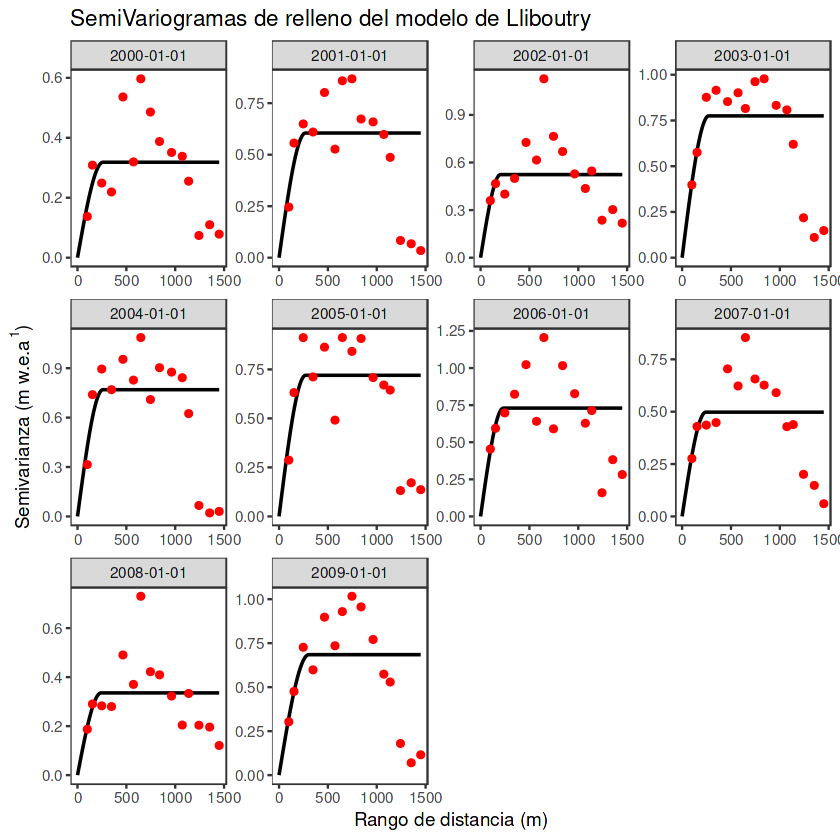

In [13]:
plot(p)

## Análisis de errores

In [14]:
  e.stkabl <- 0.1 #m w.e.yr-1 Gerbaux et al., 2005 e.stkabl <- 0.1
  e.densabl <- 0.00 # d_acc = 0.9
  e.pitacc <- 0.4 #m w.e.yr-1 Gerbaux et al., 2005 e.pitacc <- 0.4
  e.densacc <- 0.025 # d_acc = 0.5

### Error de la medición del punto, considerando el número de stacks

In [15]:
e.Abl <- e.stkabl/sqrt(n.stk.abl)
e.Acc <- ifelse(n.stk.acc==0, 0, e.pitacc/sqrt(n.stk.acc))
e_mesMB <- sqrt(e.Abl^2+e.Acc^2)

### Densidad de error, considerando el número de stacks

In [16]:
e_dcice <- e.densabl/sqrt(n.stk.abl)
e_dcfirm <- ifelse(n.stk.acc==0, 0, e.densacc/sqrt(n.stk.acc))
e_dc <- sqrt(e_dcfirm^2+e_dcice^2)

### Error por modelo de interpolación

In [17]:
e_glc.point.w.tot <- sqrt(e_mesMB^2+(sum(B_LMf_w$B_LMf_w_a)^2)*(e_dc^2))*sqrt(length(Nyear))
e_glc.point.idw.tot <- sqrt(e_mesMB^2+(sum(B_LMf_idw$B_LMf_idw_a)^2)*(e_dc^2))*sqrt(length(Nyear))
e_glc.point.krg.tot <- sqrt(e_mesMB^2+(sum(B_LMf_krg$B_LMf_krg_a)^2)*(e_dc^2))*sqrt(length(Nyear))

### Representatividad local de medidas locales

In [18]:
e_repres.yr <- sd(unlist(bit_LMf[-c(1:3)]), na.rm = T) / sqrt(unlist(lapply(stat.idw.CV_LMf, function(sublist) sublist[[1]]), use.names=F)[1])
e_repres.tot <- sd(unlist(bit_LMf[-c(1:3)]), na.rm = T) / sqrt(unlist(lapply(stat.idw.CV_LMf, function(sublist) sublist[[1]]), use.names=F)[1])

### Error del método de interpolación de área ponderada

In [19]:
std.w <- stat.w.sd^2
n_obs <- unlist(lapply(stat.idw.CV_LMf, function(sublist) sublist[[1]]), use.names=F)
e_w_sd.tot <- sqrt(sum(std.w)/((n_obs[1]*length(Nyear))-length(Nyear))) 

### Error del método de interpolación IDW

In [20]:
std.idw <- unlist(lapply(stat.idw.CV_LMf, function(sublist) sublist[[5]]), use.names=F)^2
n_obs <- unlist(lapply(stat.idw.CV_LMf, function(sublist) sublist[[1]]), use.names=F)
e_idw_sd.tot <- sqrt(sum(std.idw)/((n_obs[1]*length(Nyear))-length(Nyear)))

### Error del método de interpolación Kriging

In [21]:
std.krg <- unlist(lapply(stat.krg.CV_LMf, function(sublist) sublist[[5]]), use.names=F)^2
n_obs <- unlist(lapply(stat.krg.CV_LMf, function(sublist) sublist[[1]]), use.names=F)
e_krg_sd.tot <- sqrt(sum(std.krg)/((n_obs[1]*length(Nyear))-length(Nyear)))

### Error espacial

In [22]:
e_glc.spatial.w.tot <- sqrt(e_repres.tot^2+e_w_sd.tot^2)
e_glc.spatial.idw.tot <- sqrt(e_repres.tot^2+e_idw_sd.tot^2)
e_glc.spatial.krg.tot <- sqrt(e_repres.tot^2+e_krg_sd.tot^2)
rm(std.idw, std.krg) #std.w, n_obs

### Error de cambios de área superficial

Se asume 5m de error en la determinación del área

In [23]:
e_glac.area.w.tot <-  e_glc.point.w.tot * as.numeric((0.5*st_length(st_boundary(shape_list[[1]]))*3)/st_area(shape_list[[1]])) 
e_glac.area.idw.tot <- e_glc.point.idw.tot * as.numeric((0.5*st_length(st_boundary(shape_list[[1]]))*3)/st_area(shape_list[[1]])) 
e_glac.area.krg.tot <- e_glc.point.krg.tot * as.numeric((0.5*st_length(st_boundary(shape_list[[1]]))*3)/st_area(shape_list[[1]])) 

### Error del balance de masa glaciológico

In [24]:
E_glc.w.tot <- sqrt(e_glc.point.w.tot^2+e_glc.spatial.w.tot^2+e_glac.area.w.tot^2)
E_glc.w.yr <-  E_glc.w.tot / sqrt(length(Nyear))

E_glc.idw.tot <- sqrt(e_glc.point.idw.tot^2+e_glc.point.idw.tot^2+e_glac.area.idw.tot^2)
E_glc.idw.yr <- E_glc.idw.tot / sqrt(length(Nyear))

E_glc.krg.tot <- sqrt(e_glc.point.krg.tot^2+e_glc.point.krg.tot^2+e_glac.area.krg.tot^2)
E_glc.krg.yr <- E_glc.krg.tot / sqrt(length(Nyear)) 